## Attempt 3 

GPs are hard to scale, and solving problems with more than 1000 samples can be very challenging. One way to scale is to use GPUs, which can allow scaling upto 10K points and maybe 100K points with multiple GPUs. Here we try simpler methods. 

To get around this obstacle we can use different strategies to retrieve 1000 points from the data set. There are three ways:
- Squarish boxes strategy: make boxes with ~1000 points, map for the box, and then keep moving over the domain. Each box has a few dives and as part of the depth range.
- Long rectangle strategy: cover large number of dives, but over very few depth levels.
- Stochastic : randomly select 1000 points from some range of dives. 

Each strategy has potential pros and cons. Here we use the stochastic method and use GPy library. 


In [6]:
import numpy as np
import GPy
import xarray as xr
import gsw 

from matplotlib import pyplot as plt
from cmocean import cm as cmo
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

dens_659 = gsw.sigma0(ds_659.salinity, ds_659.temperature)
dens_660 = gsw.sigma0(ds_660.salinity, ds_660.temperature)
ds_659['density'] = xr.DataArray(
            data=dens_659,
            coords=ds_659.coords,
            dims=ds_659.dims,
            name='density'
        )

ds_660['density'] = xr.DataArray(
            data=dens_660,
            coords=ds_660.coords,
            dims=ds_660.dims,
            name='density'
        )

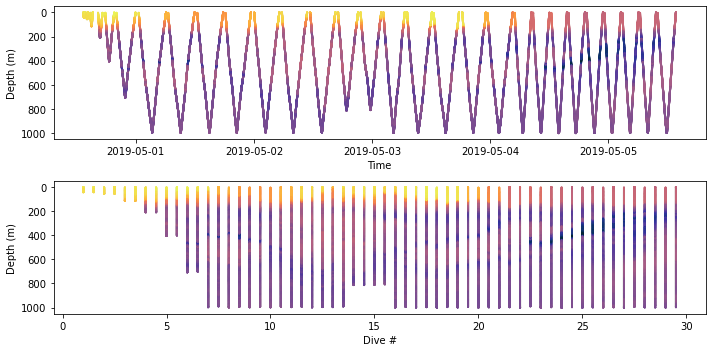

In [15]:
ndives = 30

plt.figure(figsize=(10, 5))

plt.subplot(211)
plt.scatter(ds_659.time.where(ds_659.dives<ndives, drop=True), 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Time')
plt.ylabel('Depth (m)')

plt.subplot(212)
plt.scatter(ds_659.dives.where(ds_659.dives<ndives, drop=True), 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Dive #')
plt.ylabel('Depth (m)')
plt.tight_layout()

In [195]:
# Select some data

npts = 3000

dive_start = 7
dive_end = 20

ds_659_sel= ds_659.where(ds_659.dives<dive_end 
                        ).where(ds_659.dives>dive_start
                               ).dropna('ctd_data_point')


In [196]:
ds_659_sel

<xarray.Dataset>
Dimensions:      (ctd_data_point: 43953)
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure     (ctd_data_point) float64 991.3 990.8 990.3 ... 0.8391 0.6013
    latitude     (ctd_data_point) float64 -51.36 -51.36 -51.36 ... -51.13 -51.13
    longitude    (ctd_data_point) float64 30.48 30.48 30.48 ... 32.21 32.21
    temperature  (ctd_data_point) float64 2.079 2.081 2.081 ... 3.258 3.255
    salinity     (ctd_data_point) float64 34.69 34.69 34.69 ... 33.85 33.85
    dives        (ctd_data_point) float64 7.5 7.5 7.5 7.5 ... 19.5 19.5 19.5
    time         (ctd_data_point) datetime64[ns] 2019-05-01T03:24:39.70099635...
    density      (ctd_data_point) float64 27.59 27.59 27.59 ... 26.82 26.82

In [197]:
# convert time to days+fraction
time_659 = ds_659_sel.time - np.datetime64('2019-01-01')
time_659 = (time_659 / np.timedelta64(1,'D'))

In [214]:
nstep = 40
time_sel = time_659[0:-1:nstep]
pressure_sel = ds_659_sel.pressure[0:-1:nstep]
density_sel = ds_659_sel.density[0:-1:nstep]
temperature_sel = ds_659_sel.temperature[0:-1:nstep]

In [238]:
time_sel

<xarray.DataArray 'time' (ctd_data_point: 1099)>
array([120.14212617, 120.14444098, 120.14675581, ..., 122.95592249,
       122.95823729, 122.96055212])
Dimensions without coordinates: ctd_data_point

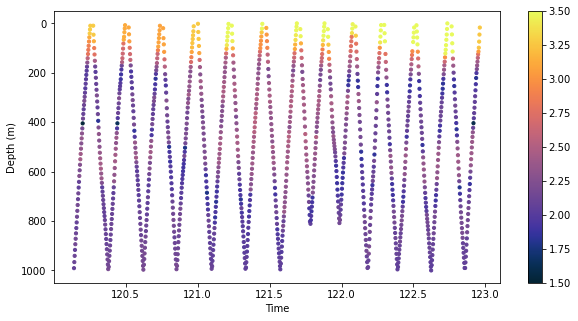

In [216]:
ndives = 30

plt.figure(figsize=(10, 5))

plt.subplot(111)
plt.scatter(time_sel, 
            pressure_sel, 
            c = temperature_sel, 
            s=10, cmap=cmo.thermal, vmin=1.5, vmax=3.5)

plt.gca().invert_yaxis()

plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.colorbar()

In [217]:
nsampes = len(time_sel)
X2 = np.zeros((nsampes,2))
Y =  np.zeros((nsampes,1))

X2[:,0] = time_sel
X2[:,1] = pressure_sel

Y[:,0] = temperature_sel

In [218]:
kRBF = GPy.kern.RBF(2, active_dims=[0,1], ARD=True)
kMATERN32 = GPy.kern.Matern32(2, active_dims=[0,1], ARD=True)

mRBF = GPy.models.GPRegression(X2, Y, kRBF)
mMATERN32 = GPy.models.GPRegression(X2, Y, kMATERN32)

In [209]:
k

rbf.,value,constraints,priors
variance,1.90625842126784,+ve,
lengthscale,"(2,)",+ve,


In [210]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.90625842126784,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.015406417866912062,+ve,


In [211]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.88846144,+ve,
[1],140.86277259,+ve,


In [212]:
m.optimize_restarts(5)

Optimization restart 1/5, f = -281.2804111792947
Optimization restart 2/5, f = -138.1771264919468
Optimization restart 3/5, f = -281.280411079033
Optimization restart 4/5, f = -277.3372952405525
Optimization restart 5/5, f = -281.2804111500959


In [219]:
mRBF.optimize_restarts(5)

Optimization restart 1/5, f = -777.3818386447866
Optimization restart 2/5, f = -777.3818389589112
Optimization restart 3/5, f = -777.3818385278279
Optimization restart 4/5, f = -602.4592061533222
Optimization restart 5/5, f = -777.3818385347357


In [220]:
mRBF

GP_regression.,value,constraints,priors
rbf.variance,1.5945583943015535,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.007144750867851097,+ve,


In [221]:
mMATERN32.optimize_restarts(5)

Optimization restart 1/5, f = -443.53148242839325
Optimization restart 2/5, f = -819.2166797175543
Optimization restart 3/5, f = -452.0879759083789
Optimization restart 4/5, f = -440.717822293072
Optimization restart 5/5, f = -442.87627936583294


In [222]:
mMATERN32

GP_regression.,value,constraints,priors
Mat32.variance,24.67731299057425,+ve,
Mat32.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.1122284485075603e-71,+ve,


In [224]:
mMATERN32.Mat32.lengthscale

index,GP_regression.Mat32.lengthscale,constraints,priors
[0],1.44906498,+ve,
[1],407.20369939,+ve,


In [ ]:
m.rbf.lengthscale

In [225]:
# create test points 

time_test = np.linspace(np.min(X2[:,0]), np.max(X2[:,0]), 50)
pressure_test = np.linspace(0,1000, 100)


In [226]:
[Tg, Pg] = np.meshgrid(time_test, pressure_test)

In [227]:
Xtest = np.vstack((Tg.ravel(), Pg.ravel())).T

In [228]:
meanRBF, covRBF = mRBF.predict(Xtest, full_cov=False)
meanMATERN32, covMATERN32 = mMATERN32.predict(Xtest, full_cov=False)

In [229]:
sampMATERN32 = mMATERN32.posterior_samples_f(Xtest, 1)

In [230]:
sampRBF = mRBF.posterior_samples_f(Xtest, 1)

In [231]:
# Do a linear interpolation 
from scipy.interpolate import griddata
temp_lin_grid = griddata(X2, Y, (Tg, Pg), method='linear', rescale=True)

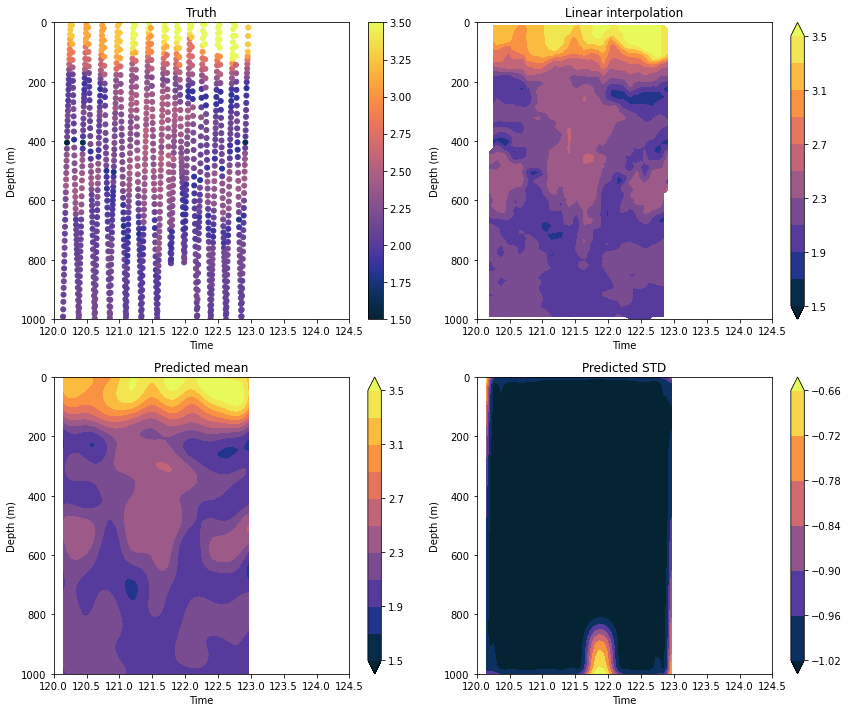

In [233]:

plt.figure(figsize=(12,10))


plt.subplot(221)
plt.scatter(time_sel, 
            pressure_sel, 
            c = temperature_sel, 
            s=25, cmap=cmo.thermal, vmin=1.5, vmax=3.5)
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Truth')


plt.subplot(222)
plt.contourf(Tg, Pg, temp_lin_grid[:,:,0],
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Linear interpolation')


plt.subplot(223)
plt.contourf(Tg, Pg, meanRBF.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted mean')

plt.subplot(224)
plt.contourf(Tg, Pg, np.log10(covRBF.reshape(Tg.shape)**0.5),
            cmap=cmo.thermal, extend='both', 
             )
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted STD')

plt.tight_layout()

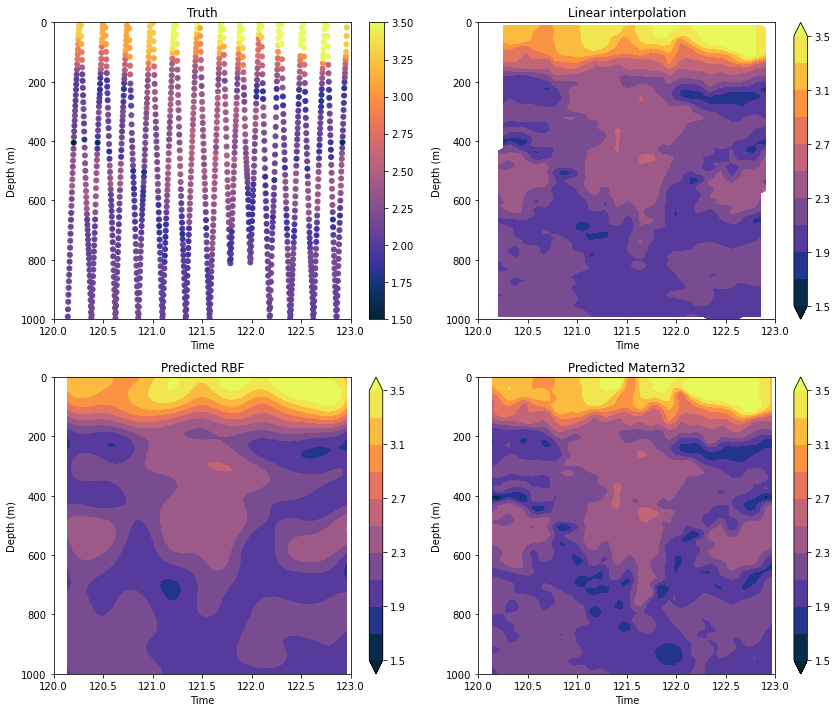

In [237]:
day_start = 120
day_end = 123

plt.figure(figsize=(12,10))


plt.subplot(221)
plt.scatter(time_sel, 
            pressure_sel, 
            c = temperature_sel, 
            s=25, cmap=cmo.thermal, vmin=1.5, vmax=3.5)
plt.colorbar()

plt.xlim([day_start, day_end])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Truth')


plt.subplot(222)
plt.contourf(Tg, Pg, temp_lin_grid[:,:,0],
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([day_start, day_end])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Linear interpolation')


plt.subplot(223)
plt.contourf(Tg, Pg, meanRBF.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([day_start, day_end])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted RBF')

plt.subplot(224)
plt.contourf(Tg, Pg, meanMATERN32.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([day_start, day_end])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted Matern32')

plt.tight_layout()

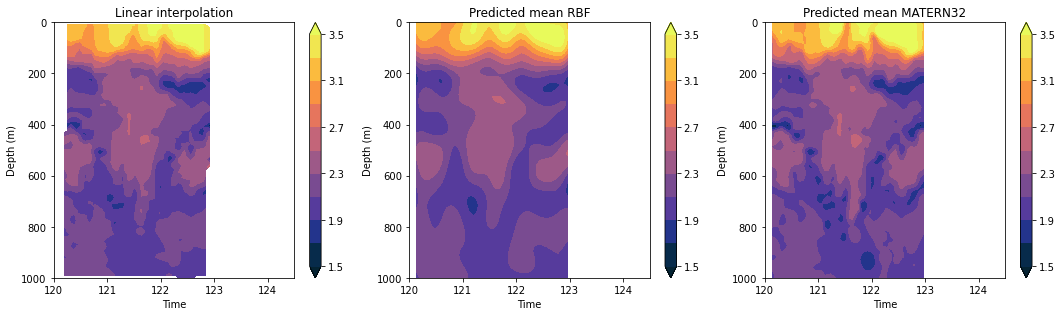

In [234]:

plt.figure(figsize=(15,4.5))


plt.subplot(131)
plt.contourf(Tg, Pg, temp_lin_grid[:,:,0],
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Linear interpolation')


plt.subplot(132)
plt.contourf(Tg, Pg, meanRBF.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted mean RBF')

plt.subplot(133)
plt.contourf(Tg, Pg, meanMATERN32.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted mean MATERN32')

plt.tight_layout()

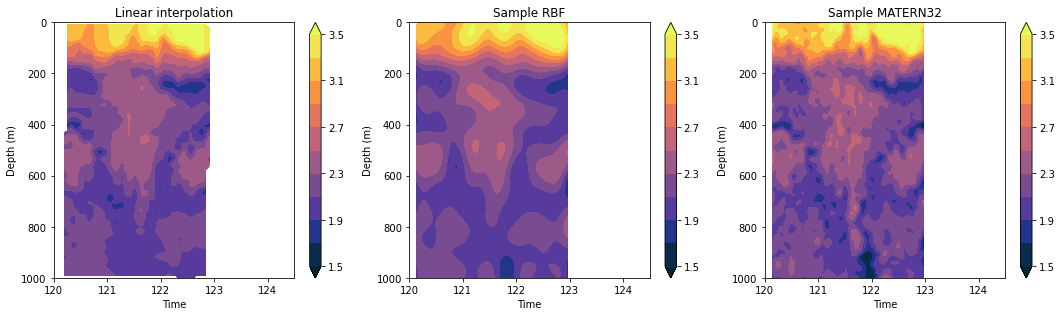

In [235]:

plt.figure(figsize=(15,4.5))


plt.subplot(131)
plt.contourf(Tg, Pg, temp_lin_grid[:,:,0],
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Linear interpolation')


plt.subplot(132)
plt.contourf(Tg, Pg, sampRBF.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Sample RBF')

plt.subplot(133)
plt.contourf(Tg, Pg, sampMATERN32.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Sample MATERN32')

plt.tight_layout()

In [184]:
mMATERN32.posterior_samples_f()

(5000, 1)

In [185]:
meanMATERN32.shape

(5000, 1)